In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data pre-processing
from scipy.io import loadmat
from scipy.ndimage import convolve1d

# Machine Learning
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV


# Part 1

## 1.1 Visualize and preprocess the data
Note: data is already partially preprocessed on the original database

### Loading and visualizing data

In [20]:
# load EMG data
data = loadmat("data/part_1/S2_A1_E1.mat")

# Performing a copy of the data
emg_rectified = data["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'Shape of Data \n    EMG: {emg_rectified.shape}\n    Stimulus {stimulus.shape}\n   Repetition {repetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')


Shape of Data 
    EMG: (100686, 10)
    Stimulus (100686, 1)
   Repetition (100686, 1)
***
Number of 
    Movements: 12
    Repetitions: 10


### Assessment of preprocessing quality


Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

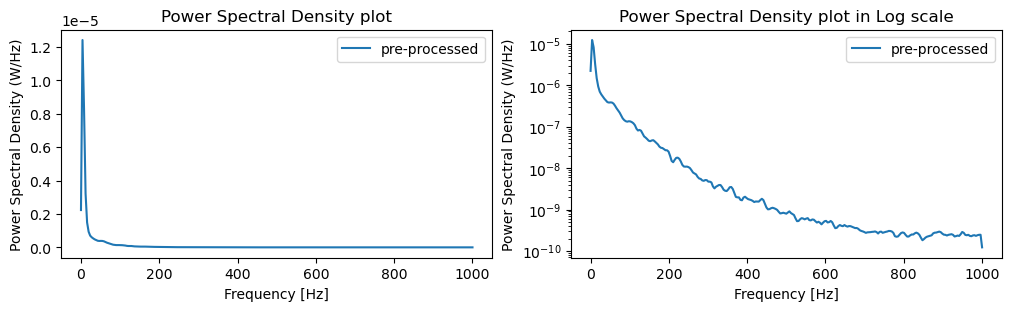

In [21]:
from scipy import signal
from scipy.signal import welch

fs = 2000 # Found in Atzori et al. 2014

#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_post, Pxx_post = welch(emg_rectified[:, 5],fs = fs,  nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_post, Pxx_post, linestyle="-", label="pre-processed")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_post, Pxx_post, linestyle="-", label="pre-processed")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

#### Observations
The signal appears to be effectively free of 50 Hz powerline noise and its harmonics. Therefore, no additional preprocessing is required for noise removal. 

### Visualizing the stimulus and repetitions values

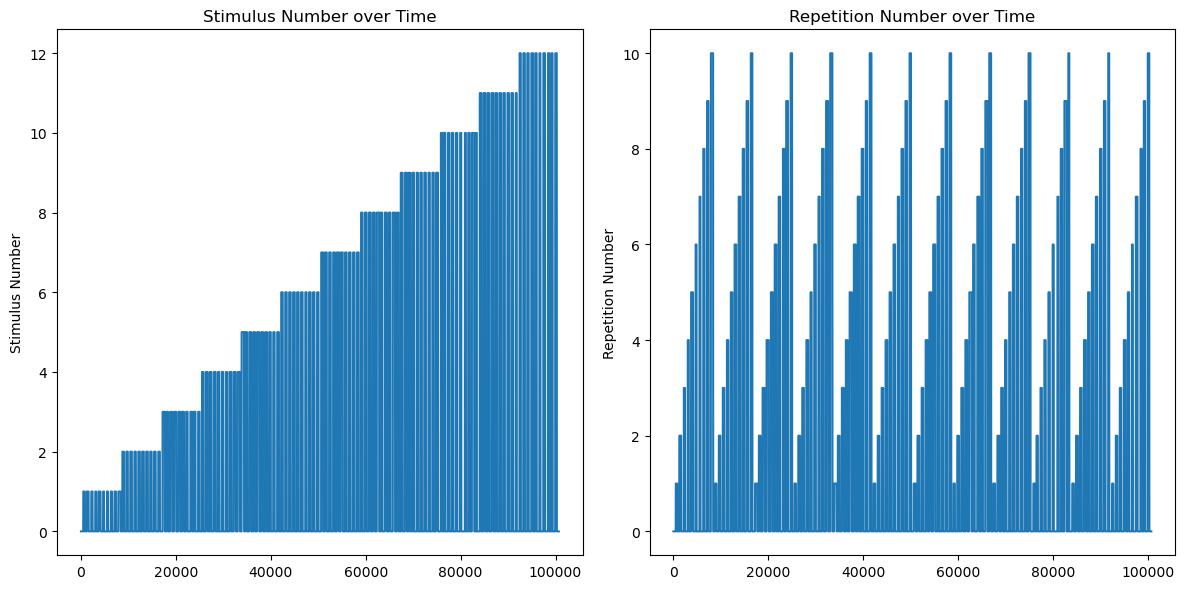

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(stimulus)
ax[0].set_title('Stimulus Number over Time')
ax[0].set_ylabel('Stimulus Number')
ax[1].plot(repetition)
ax[1].set_title('Repetition Number over Time')
ax[1].set_ylabel('Repetition Number')
plt.tight_layout()
plt.show()

### Visualizing the length of the repetitions for each movement

In [23]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### Plotting the 10 EMG Channels to discard faulty recordings
Visualizing each channel across different movements and repetitions to identify weird-looking data

In [24]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
max_amplitudes = np.zeros(n_channels) # Keeping track of the max amplitude in each EMGs to later use for trial quality assessment data
amplitudes_averaged = np.zeros(n_channels) # Keeping track of the mean amplitude in each EMGs to later use for trial quality assessment data

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 
        
        # Compare the channels mean amplitude element-wise to the maximal amplitudes stored so far
        mean_values = emg_rectified[idx, :].mean(axis=0)
        max_amplitudes = np.maximum(max_amplitudes,mean_values)
        amplitudes_averaged += mean_values

# Averaging the mean amplitudes over a window per channel
amplitudes_averaged /= (n_repetitions * n_stimuli)

for i in range(n_channels):
    print(f"Channel {i+1}: Mean amplitude = {round(amplitudes_averaged[i], 3)} | Max amplitude = {round(max_amplitudes[i], 3)} ")


Channel 1: Mean amplitude = 0.786 | Max amplitude = 1.64 
Channel 2: Mean amplitude = 0.508 | Max amplitude = 1.027 
Channel 3: Mean amplitude = 0.285 | Max amplitude = 0.708 
Channel 4: Mean amplitude = 0.242 | Max amplitude = 0.845 
Channel 5: Mean amplitude = 0.033 | Max amplitude = 0.164 
Channel 6: Mean amplitude = 0.011 | Max amplitude = 0.049 
Channel 7: Mean amplitude = 0.024 | Max amplitude = 0.133 
Channel 8: Mean amplitude = 0.358 | Max amplitude = 1.172 
Channel 9: Mean amplitude = 0.656 | Max amplitude = 1.953 
Channel 10: Mean amplitude = 0.195 | Max amplitude = 0.834 


### Assesssing whether some trials need to be removed 
The code below loops through the data and assesses for each channel whether the mean amplitude over a trial is below a certain threshold as compared to the maximal value ever recorded (or the mean value across all trials) for this channel

In [25]:
# Setting up an arbitrary threshold of 1%
threshold = 1e-2
k = 0

print(f"With a threshold of {threshold*100} % of maximal and mean amplitude, the following trials have near-zero amplitude\n" )

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        comparison_max = emg_windows[stimuli_idx][repetition_idx].mean(axis=0) < threshold * max_amplitudes # Comparing with max amplitude: Returns boolean where it is true
        comparison_mean = emg_windows[stimuli_idx][repetition_idx].mean(axis=0) < threshold * amplitudes_averaged # Comparing with mean amplitude: Returns boolean where it is true
        if any(comparison_max):
            k +=1
            print(f"{k}) Stimulus: {stimuli_idx} - Repetition {repetition_idx} => Channel(s) below MAX threshold: {np.arange(1, n_channels+1)[comparison_max]}")
        if any(comparison_mean):
            k +=1
            print(f"{k}) Stimulus: {stimuli_idx} - Repetition {repetition_idx} => Channel(s) below MEAN threshold: {np.arange(1, n_channels+1)[comparison_mean]}")

With a threshold of 1.0 % of maximal and mean amplitude, the following trials have near-zero amplitude

1) Stimulus: 7 - Repetition 2 => Channel(s) below MAX threshold: [4]
2) Stimulus: 7 - Repetition 6 => Channel(s) below MAX threshold: [4]
3) Stimulus: 9 - Repetition 3 => Channel(s) below MAX threshold: [4]
4) Stimulus: 9 - Repetition 5 => Channel(s) below MAX threshold: [4]
5) Stimulus: 9 - Repetition 8 => Channel(s) below MAX threshold: [4]


### Observations
With this threshold of mean amplitude of signal for each channel compared to its maximal and mean value across all trials, we can see that few trials are flagged. Channel number 4 is always the issue on this subset of trials, but since this occurence is rare and limited to channel 4, we decide not to proceed with trial removal and keep the whole dataset.

### Plotting Specific Repetitions
Using the quality assessment from above, we can visualize the flagged trials to assess whether the signal is a faulty zero-amplitude recording or simply a low-amplitude recording.

Text(0.5, 0.98, 'Envelopes of the EMG signal')

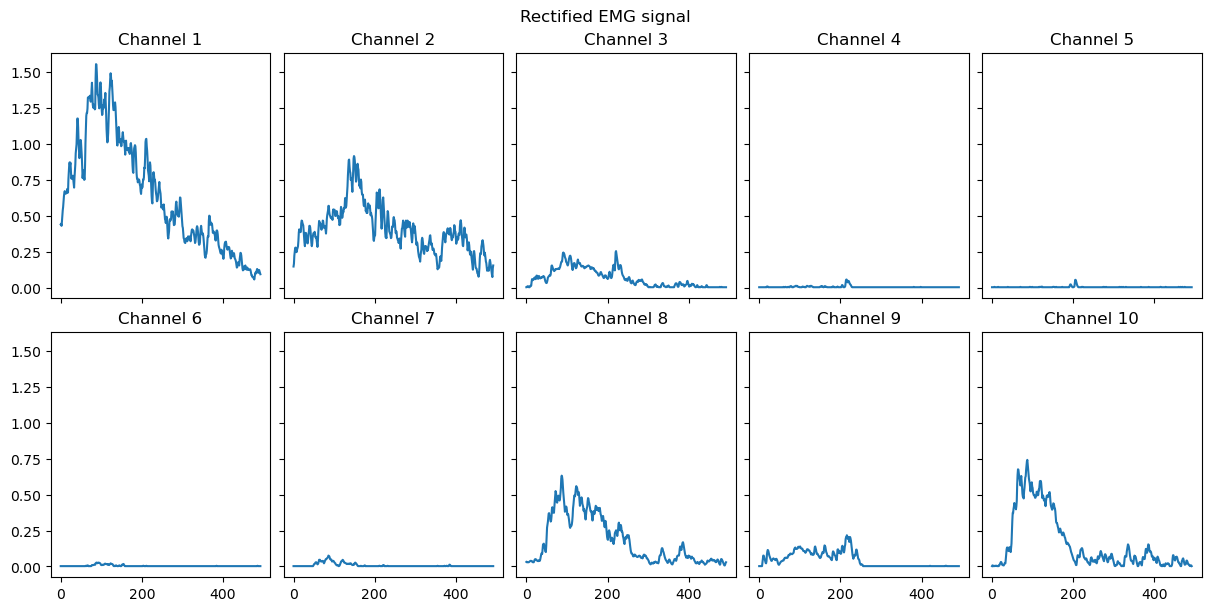

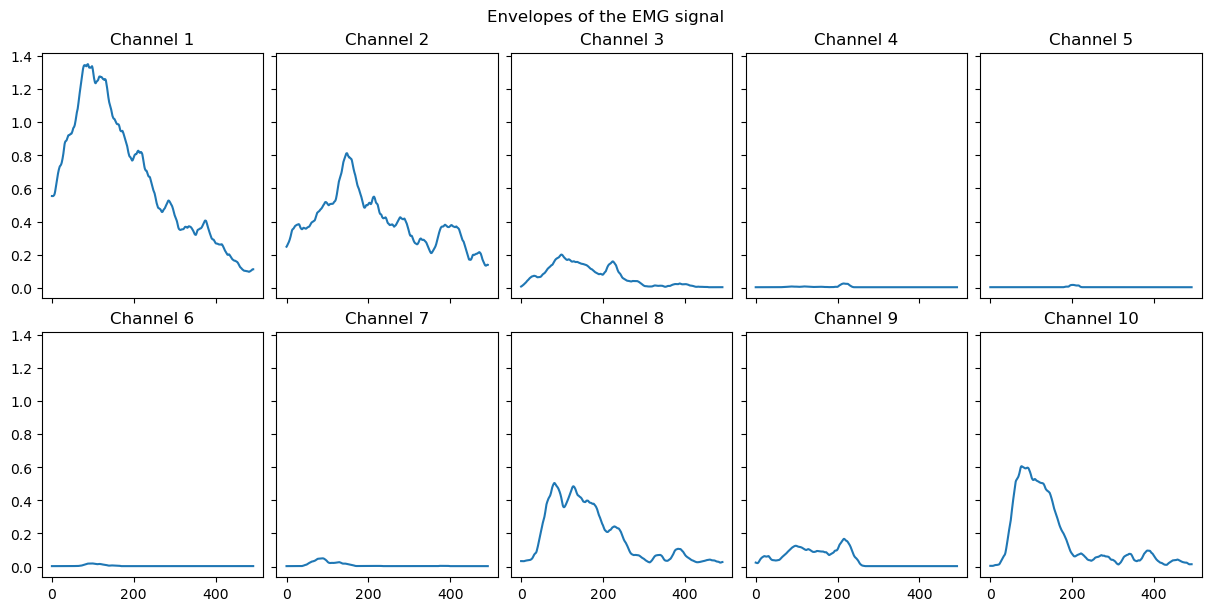

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

# Selecting the stimulus and repetition to plot the 10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
stimulus_id = 9
repetition_id = 8

# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Some channels have very low amplitude of signal on given trials, but should not be naively discarded. It is important to distinguish between a faulty recording from a channel (e.g. due to drying of the gel, EMG detachment) and a low amplitude recording from a channel that actually represent the reality and might still provide useful information for a ML classifier. On this specific dataset, the latter option seem to be the reason for the observed low amplitude recordings of certain channels.

## 1.2 & 1.3 Extracting Features and Splitting Data into Train-Test-Validation Sets

### Step 1: Select & Define the features of interest

In [27]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)
# Variance
var = lambda x: np.var(x, axis=0)

### Step 2: Build the dataset

In [28]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

# Selecting the features of interest
features_names = ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc', 'var']
features = [mav, std, maxav, rms, wl, ssc, var]

dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified,
    stimulus=stimulus,
    repetition=repetition,
    features=features
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 70)
labels dimension: (120,)


### Step 3: Split the dataset into Train-Test (Validation split done later in cross-validation)

In [29]:
# Splitting into Training (75%) and Testing Set (25%)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, stratify = labels) # Ensuring a correct stratification in the train and test sets

# Standardizing data w.r.t to X_train
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform both training and test sets with this scaler
X_test_z = scaler.transform(X_test)   
print(f"Shapes =  X_train: {X_train_z.shape} | X_test: {X_test_z.shape}")

Shapes =  X_train: (90, 70) | X_test: (30, 70)


#### Ensuring a correct stratification of each movements in the train and test sets

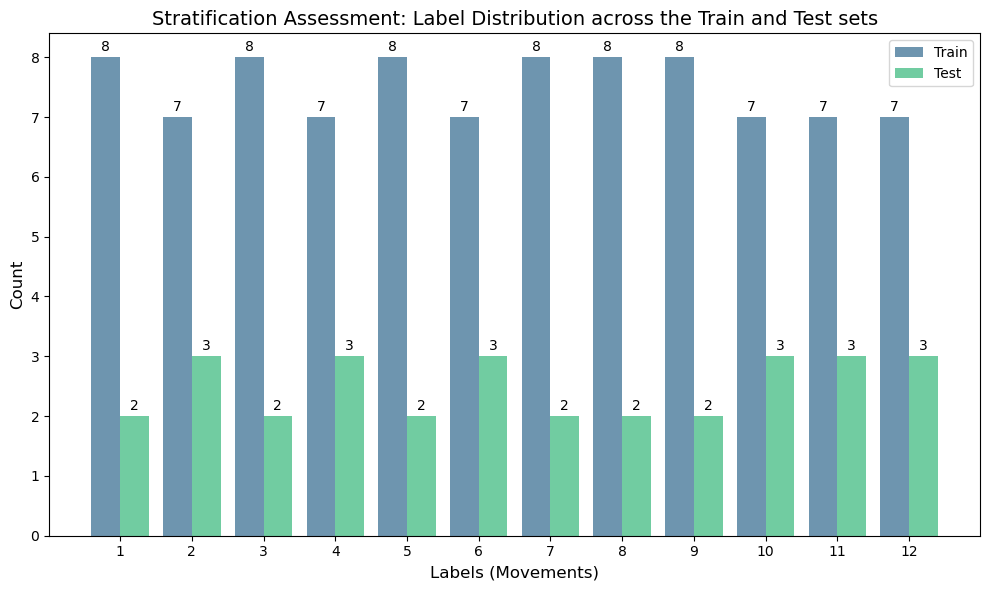

In [30]:
# Create a color palette
colors = sns.color_palette('viridis', 2)

# Count the occurrences of each label in training and test sets
unique_labels = np.unique(labels)
train_counts = [np.sum(y_train == label) for label in unique_labels]
test_counts = [np.sum(y_test == label) for label in unique_labels]

# Create a bar plot
x = np.arange(len(unique_labels), dtype=int)  # X-axis positions
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for training and test distributions
bars_train = ax.bar(x - width / 2, train_counts, width, label='Train', color=colors[0], alpha=0.7)
bars_test = ax.bar(x + width / 2, test_counts, width, label='Test', color=colors[-1], alpha=0.7)

# Add labels, set title, and incorporate the legend
ax.set_xlabel('Labels (Movements)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Stratification Assessment: Label Distribution across the Train and Test sets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(unique_labels.astype(int), fontsize=10)
ax.legend(fontsize=10)

# Annotate bars with counts
for bar in bars_train + bars_test:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Step 4. Visualizing typical values of the features across the different trials

#### Visualization 1: Focus on 2 movements and look at the mean and std value of features across the 10 repetitions for each EMG channel

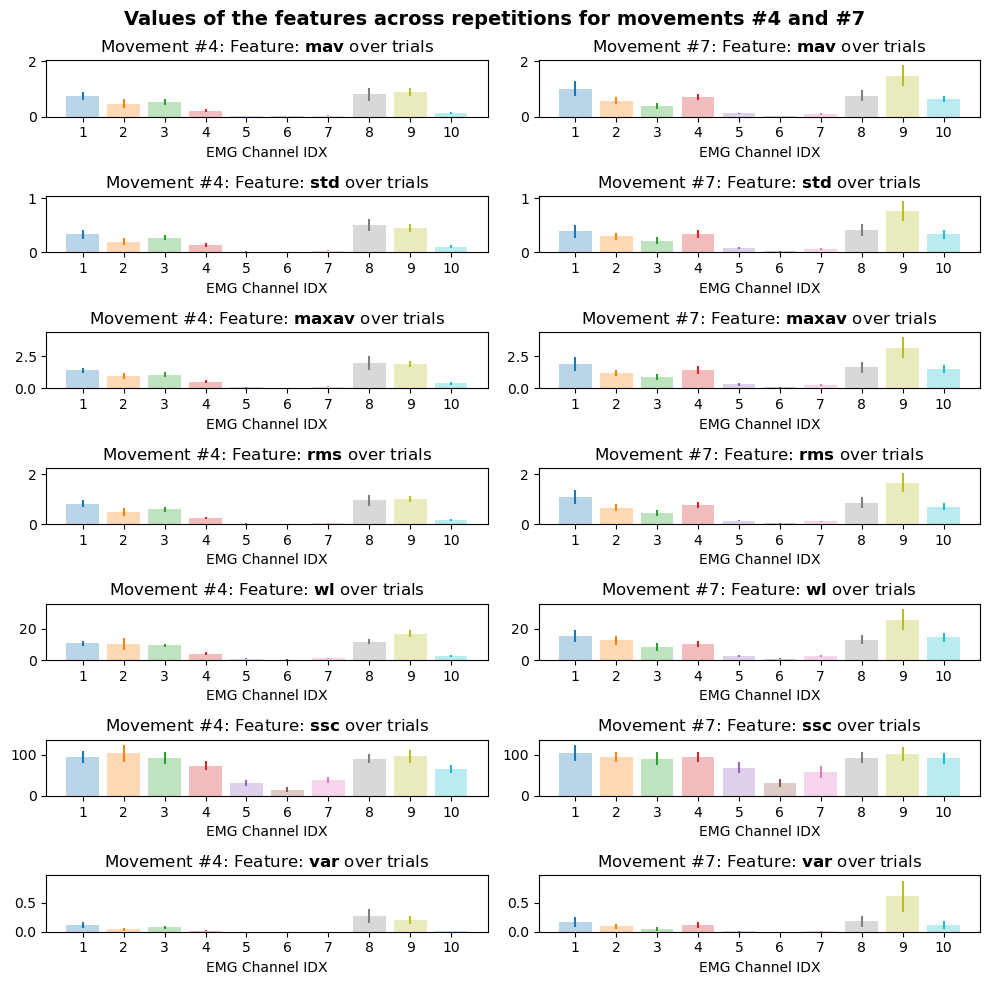

In [45]:
# Visualize values of the features across channels and repetitions of a given movement
stimuli_idx = [3, 6] # can be modified to visualize different movements

# Setting the x-axis to be the different EMG channels
x_axis = np.arange(1, number_of_emg_channels+1)

# Instantiating a subplot
fig, axs = plt.subplots(len(features), 2, figsize = (10,10))

# Define the maximal value for each feature to then plot with the same y_lim between movements
feature_max = {feature: 0 for feature in features_names}

for j, movement in enumerate(stimuli_idx):
    # Looping through the features
    for i, feature in enumerate(features_names):
        mean_feat, std_feat = np.nan, np.nan
        max_mean = 0
        for channel_idx in range(number_of_emg_channels): # Looping through each EMG channel for each feature
            idx_feature = i * number_of_emg_channels + channel_idx
            idx_movement = movement * n_repetitions # E.g. for movement 0: relevant trials are between 0:9 included

            # Computing the mean and std of the feature over the 10 repetitions for a channel
            mean_feat = np.mean(dataset[idx_movement:idx_movement + n_repetitions, idx_feature]) # Averaging over the 10 repetitions of a movement for each channel
            std_feat = np.std(dataset[idx_movement:idx_movement + n_repetitions, idx_feature])
            
            # Assess whether the value for this channel is higher than the registered max for this feature
            if mean_feat + std_feat > max_mean:
                max_mean = mean_feat + std_feat 

            # Plotting the points with the error bars
            axs[i][j].bar(x_axis[channel_idx], mean_feat, alpha=0.3)
            axs[i][j].errorbar(x_axis[channel_idx], mean_feat, yerr = std_feat)

        # Compute the max for each feature (visualization purposes)
        if max_mean > feature_max[feature]: 
            feature_max[feature] = max_mean

        # Set the y_lim for each feature to be the same across movements (10% bigger than max)
        if j == 1:
            axs[i][j].set_ylim(0, 1.1 * feature_max[feature])
            axs[i][0].set_ylim(0, 1.1 * feature_max[feature])

        # Plotting parameters
        axs[i][j].set_xticks(np.arange(1,n_channels+1))
        axs[i][j].set_xlabel("EMG Channel IDX", fontsize = 10)
        axs[i][j].set_title(f"Movement #{movement+1}: Feature: $\\bf{{{feature}}}$ over trials")
   
plt.suptitle(f"Values of the features across repetitions for movements #{stimuli_idx[0]+1} and #{stimuli_idx[1]+1}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.4 Perform classification on the data

### Hyperparameters optimization

In [33]:
# Define the SVM model
svc = SVC()

# Define the grid search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 0.1, 1, 10],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Performing the grid search with a 5-fold cross-validation
grid_search_full = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1_macro', refit=True, cv=5, verbose=1)

# Fit the grid search
grid_search_full.fit(X_train_z, y_train)

print(f"Best hyperparameters for full dataset: {grid_search_full.best_params_}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters for full dataset: {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}


## 1.5 Evaluate the performance

*** Results ***
Accuracy score: 0.9333
F1-score score: 0.9345


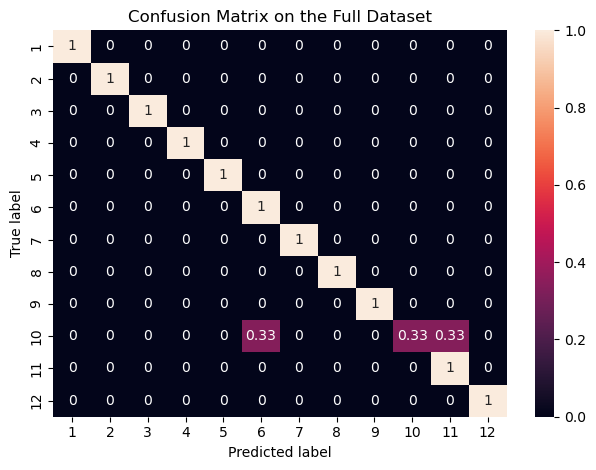

In [ ]:
# Training the model with the best parameters
best_model = grid_search_full.best_estimator_
best_model.fit(X_train_z, y_train)

# Evaluate on the test set
y_pred = best_model.predict(X_test_z)
accuracy_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred, average='macro')
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Printing results
print("*** Results ***")
print(f"Accuracy score: {round(accuracy_test, 4)}")
print(f"F1-score score: {round(f1_score_test, 4)}")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)

plt.title("Confusion Matrix on the Full Dataset")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Set the x, y ticks and labels
ax.set_xticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))
ax.set_yticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))

plt.tight_layout()

## 1.6 Perform feature selection

### Mutual information and k-best features selection

*** Mutual Information and K-Best Features Selection ***
Original feature count: 70
Reduced feature count after K-Best Selection: 20

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters for K-Best reduced dataset: {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}

*** Results ***
Accuracy of a model with 20 best features: 0.9
F1-score of a model with 20 best features: 0.8992


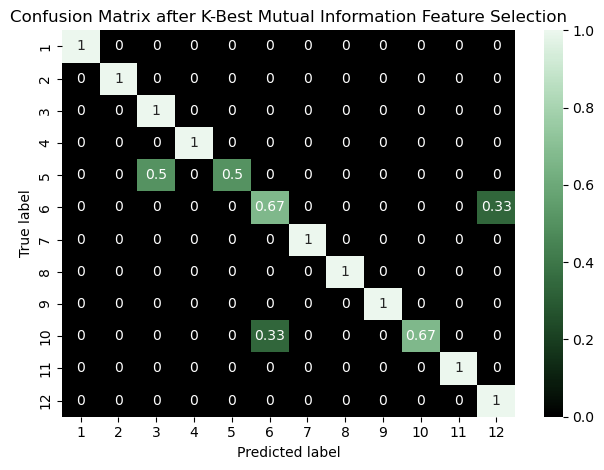

In [35]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)

# Select the top 15 features based on mutual information scores.
K = 20
k_best = SelectKBest(mutual_info_classif, k=K)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)
print("*** Mutual Information and K-Best Features Selection ***")
print(f"Original feature count: {X_train_z.shape[1]}")
print(f"Reduced feature count after K-Best Selection: {X_train_best.shape[1]}\n")

# Performing a round of hyperparameters search on this reduced dataset (grid search with a 5-fold cross-validation)
grid_search_k_best = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1_macro', refit=True, cv=5, verbose=1)

# Fit the grid search
grid_search_k_best.fit(X_train_best, y_train)
print(f"Best hyperparameters for K-Best reduced dataset: {grid_search_k_best.best_params_}")

# Predict the labels for the test set using the trained model.
y_pred = grid_search_k_best.predict(X_test_best)
accuracy_k_best = accuracy_score(y_test, y_pred)
f1_score_k_best = f1_score(y_test, y_pred, average='macro')
confmat_kbest = confusion_matrix(y_test, y_pred, normalize="true")

# Printing results
print("\n*** Results ***")
print(f"Accuracy of a model with {K} best features: {round(accuracy_k_best, 4)}")
print(f"F1-score of a model with {K} best features: {round(f1_score_k_best, 4)}")

# Plotting the confusion matrix
fig, ax = plt.subplots()
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
sns.heatmap(confmat_kbest, annot=True, ax=ax, cmap=cmap)

plt.title("Confusion Matrix after K-Best Mutual Information Feature Selection")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Set the x, y ticks and labels
ax.set_xticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))
ax.set_yticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))

plt.tight_layout()

### PCA Dimensionality Reduction
To remove redundancy from k-best features retained based on highest mutual information, we can also perform further dimensionality reduction using PCA

*** PCA Dimensionality Reduction ***
Original feature count: 20
Reduced feature count after PCA: 6

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best hyperparameters for PCA reduced dataset: {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}

*** Results ***
Accuracy of the model after PCA: 0.8992
F1-score of the model after PCA: 0.8992


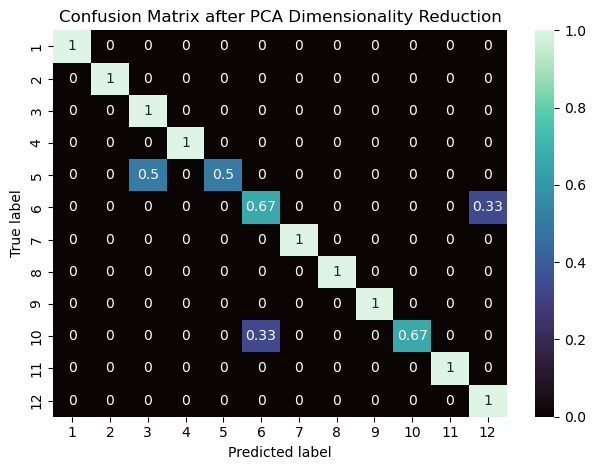

In [36]:
# Perform PCA on the selected features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_best)
X_test_pca = pca.transform(X_test_best)

print("*** PCA Dimensionality Reduction ***")
print(f"Original feature count: {X_train_best.shape[1]}")
print(f"Reduced feature count after PCA: {X_train_pca.shape[1]}\n")

# Performing a round of hyperparameters search on this reduced dataset (grid search with a 5-fold cross-validation)
grid_search_PCA = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1_macro', refit=True, cv=5, verbose=1)

# Fit the grid search
grid_search_PCA.fit(X_train_pca, y_train)
print(f"Best hyperparameters for PCA reduced dataset: {grid_search_PCA.best_params_}")


# Predict the labels for the test set using the trained model.
y_pred = grid_search_PCA.predict(X_test_pca)
accuracy_PCA = accuracy_score(y_test, y_pred)
accuracy_PCA = f1_score(y_test, y_pred, average='macro')
confmat_PCA = confusion_matrix(y_test, y_pred, normalize="true")

# Printing results
print("\n*** Results ***")
print(f"Accuracy of the model after PCA: {round(accuracy_PCA, 4)}")
print(f"F1-score of the model after PCA: {round(accuracy_PCA, 4)}")

# Plotting the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confmat_PCA, annot=True, ax=ax, cmap = 'mako')

plt.title("Confusion Matrix after PCA Dimensionality Reduction")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Set the x, y ticks and labels
ax.set_xticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))
ax.set_yticks(ticks = 0.5 + np.arange(n_stimuli), labels=np.arange(1, n_stimuli+1))

plt.tight_layout()